In [65]:
%load_ext autoreload
%autoreload 2

from datasets import DataCocoFeat
from models import RNNCaption
from optimers import OptimerAdam
from utils import check_gradient, show_training_info
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loader

In [42]:
# load data
dataloader = DataCocoFeat('./datasets/coco_captioning/', pca_features=True)
dataloader.show_info()

Training data shape:  (400135, 512)
Training labels shape:  (400135, 17)
Validation data shape:  (195954, 512)
Validation labels shape:  (195954, 17)
Number of training images:  82783
Number of validation images:  40504
Number of words:  1004


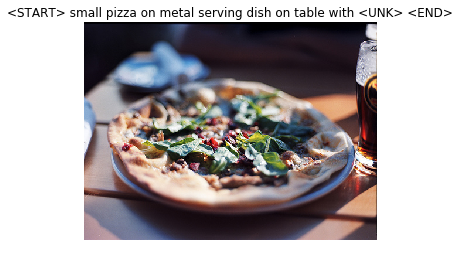

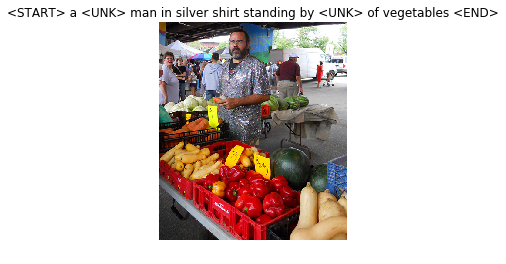

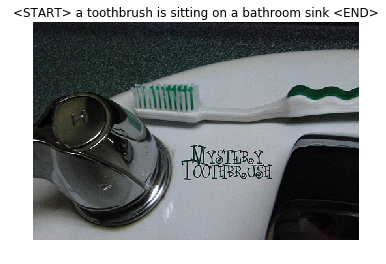

In [9]:
# show some examples
for indx in np.random.choice(dataloader.x_train.shape[0], 3, replace=False):
    img, caption = dataloader.show_by_index(indx)

# Sanity check

### Init loss

In [76]:
def get_init_model(hyperparams):
    return RNNCaption(512, None, hyperparams=hyperparams, seed=100)

# init model
model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                        'reg': 0., 'num_hidden': 64, 'num_vector': 64, 'init_scale': None})

# init loss -log(1./1004)=6.91
loss = model.backward(dataloader.x_train[0: 100, :], dataloader.y_train[0: 100])
print('Sanity check result:')
print('Init loss is', loss)

Sanity check result:
Init loss is 6.977001923015437


### Gradient check

In [54]:
# gradient check
for i in range(3):
    print('\nGradient check result - ', i + 1, ':')
    check_gradient(model, dataloader.x_train[0: 100, :], dataloader.y_train[0: 100])


Gradient check result -  1 :
Layer | Key | Numerical gradient | Calculated gradient | Relative error
<class 'models.layers.layers.Linear'> W 0.0010449303644577412 0.0010449305583519742 1.8555706822534603e-07
<class 'models.layers.layers.Linear'> b 0.00022515522779542604 0.00022515529634443545 3.044521756888399e-07
<class 'models.layers.rnn_layers.WordEmbedding'> W_embed 0.0 0.0 nan
<class 'models.layers.rnn_layers.RNN'> Wx 0.00017174270894315666 0.0001717427580634738 2.860110359986499e-07
<class 'models.layers.rnn_layers.RNN'> Wh 0.0024311930690856798 0.0024311927124426023 1.46694685904374e-07
<class 'models.layers.rnn_layers.RNN'> b -0.038360068188580954 -0.03836007255786686 1.1390192621631237e-07
<class 'models.layers.rnn_layers.LinearForRNN'> W -8.825278285939929e-05 -8.825279834186948e-05 1.7543320824249136e-07
<class 'models.layers.rnn_layers.LinearForRNN'> b 0.0009969062464421086 0.0009969063893269742 1.433282777441558e-07

Gradient check result -  2 :
Layer | Key | Numerical gr

### Overfit small dataset

In [110]:
# load small dataset
smallloader = DataCocoFeat('./datasets/coco_captioning/', pca_features=True,
                           num_train=50, num_val=50)

# init model
model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                        'reg': 0., 'num_hidden': 512, 'num_vector': 256})

# train model
optimer = OptimerAdam({'learn_rate': 5e-2, 'num_iters': 200,'batch_size': 25}, 
                      print_every=20, check_val_acc=False, check_train_acc=False)

optimer.train(model, smallloader)

# save model
model.save('./saves/RNNCaption/model_small.pkl')

0 / 200 loss is 6.911747199286562
20 / 200 loss is 14.361311007394338
40 / 200 loss is 4.947007850732924
60 / 200 loss is 1.3823806415295323
80 / 200 loss is 0.6347799270124227
100 / 200 loss is 0.5692413730980972
120 / 200 loss is 0.14816178205522135
140 / 200 loss is 0.1406115964504934
160 / 200 loss is 0.20138793653752884
180 / 200 loss is 0.22712390618861575


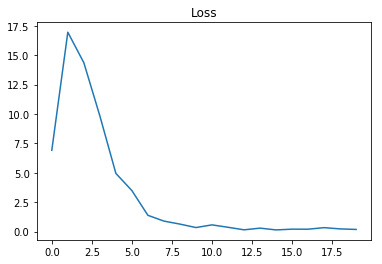

In [111]:
# plot loss curve
show_training_info(optimer)

Predicted: <START> a very clean and well decorated empty bathroom <END>


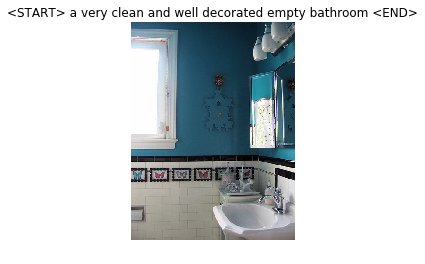

Predicted: <START> a <UNK> view of a kitchen and all of its appliances <END>


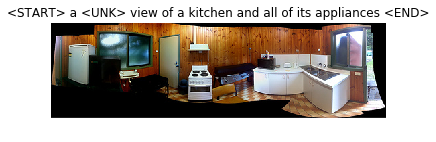

Predicted: <START> a <UNK> stop sign across the street from a red car <END>


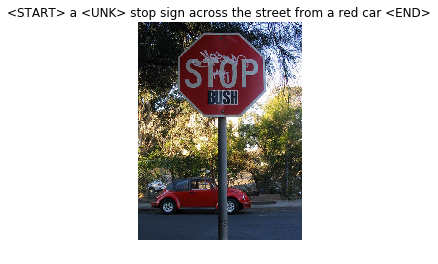

In [112]:
# test idx
idx = [0, 1, 4]

# load model
model = RNNCaption.load('./saves/RNNCaption/model_small.pkl')
caps = model.predict(smallloader.x_train[idx])

# the predicted captions
for i in range(len(caps)):
    print('Predicted:', smallloader.decode_captions(caps[i]))
    smallloader.show_by_index(idx[i])